In [9]:
import kagglehub
import os
import zipfile

# Download latest version of the dataset
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Path to dataset files:", path)

# Extract dataset if it's in a zip format
dataset_zip = os.path.join(path, "plantdisease.zip")
if os.path.exists(dataset_zip):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(path)
    print("Dataset extracted successfully.")
else:
    print("No zip file found, dataset might be already extracted.")


100%|██████████| 658M/658M [00:07<00:00, 86.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1
No zip file found, dataset might be already extracted.


In [10]:
ls -l /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1

total 8
drwxr-xr-x  3 root root 4096 Apr  5 16:43 plantvillage/
drwxr-xr-x 19 root root 4096 Apr  5 16:43 PlantVillage/


In [11]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1"
files = os.listdir(dataset_path)
print("Dataset Files:", files)


Dataset Files: ['plantvillage', 'PlantVillage']


In [12]:
import os

image_extensions = ('.png', '.jpg', '.jpeg')

all_images = []
for root, _, files in os.walk(dataset_path):  # Recursively search all subdirectories
    all_images.extend([os.path.join(root, f) for f in files if f.endswith(image_extensions)])

print(f"Found {len(all_images)} images in the dataset.")


Found 312 images in the dataset.


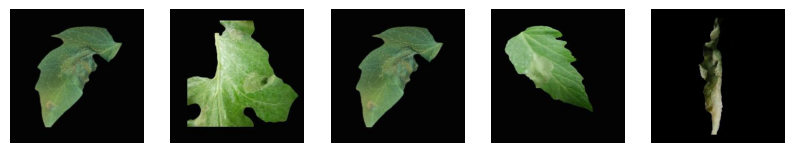

In [13]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Select random images (limit to available count)
num_images_to_display = min(5, len(all_images))
random_images = random.sample(all_images, num_images_to_display)

# Display images
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


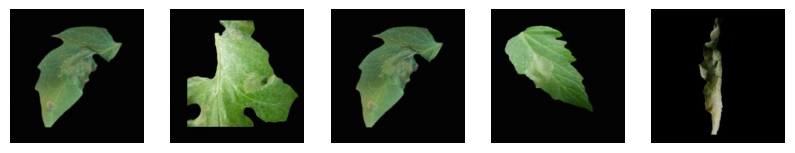

In [14]:
import cv2
import numpy as np

# Define image size for preprocessing
IMG_SIZE = (224, 224)

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img / 255.0  # Normalize
    return img

# Process first 5 images as a test
preprocessed_images = [preprocess_image(img_path) for img_path in random_images]

# Show preprocessed images
plt.figure(figsize=(10, 5))
for i, img in enumerate(preprocessed_images):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [15]:
import os
import shutil
import random

dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

split_ratio = 0.8  # ✅ Add this line

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop through each class and split images
for class_name in os.listdir(dataset_path):
    if class_name in ["train", "val"]:
        continue

    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Create class folders in train and val
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Move images
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        for img in val_images:
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_dir, img))

        # Optionally remove original folder
        if not os.listdir(class_path):
            os.rmdir(class_path)

print("✅ Dataset successfully split into Train and Validation sets.")


✅ Dataset successfully split into Train and Validation sets.


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Reload generators with larger batch size
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,  # ⬆️ Speed up CPU training
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical"
)

# ✅ Build model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze for faster training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train with fewer epochs (increase later)
history = model.fit(train_generator, epochs=5, validation_data=val_generator)


Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1148s 4s/step - accuracy: 0.6390 - loss: 1.1542 - val_accuracy: 0.8607 - val_loss: 0.4437
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1222s 5s/step - accuracy: 0.8461 - loss: 0.4597 - val_accuracy: 0.8544 - val_loss: 0.4387
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1185s 5s/step - accuracy: 0.8700 - loss: 0.3843 - val_accuracy: 0.8846 - val_loss: 0.3419
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1150s 4s/step - accuracy: 0.8936 - loss: 0.3170 - val_accuracy: 0.8771 - val_loss: 0.3875
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1195s 5s/step - accuracy: 0.8983 - loss: 0.2895 - val_accuracy: 0.8919 - val_loss: 0.3302


65/65 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.8916 - loss: 0.3240
✅ Validation Accuracy: 89.19%


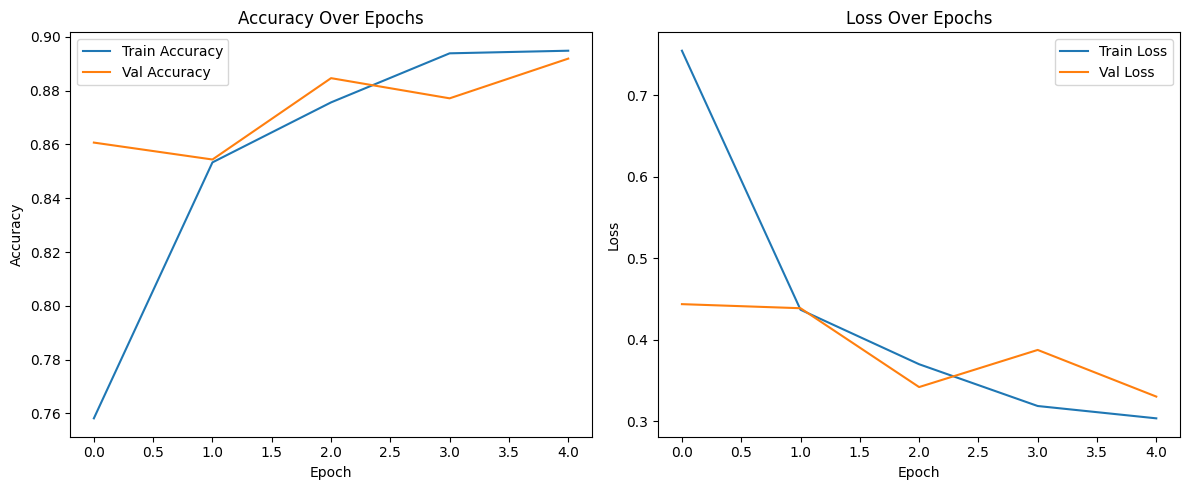

In [17]:
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Validation Accuracy: {accuracy * 100:.2f}%")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
model.save("crop_disease_model.h5")
print("✅ Model saved successfully as crop_disease_model.h5")



✅ Model saved successfully as crop_disease_model.h5


In [19]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())


Current working directory: /content
Files in current directory: ['.config', 'drive', 'crop_disease_model.h5', 'sample_data']


In [20]:
model.save("/content/crop_disease_model.h5")
print("✅ Model saved to /content/crop_disease_model.h5")


✅ Model saved to /content/crop_disease_model.h5


In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
model.save('/content/drive/MyDrive/crop_disease_model.h5')


In [23]:
from google.colab import files
files.download("crop_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>